In [2]:
%bq query
SELECT
  *
FROM
  bubbles.gcpugmlday
ORDER BY
  score DESC,
  magnitude DESC
LIMIT
  10

IndentationError: unexpected indent (<ipython-input-2-655814443faf>, line 3)

In [2]:
import pandas as pd

query = "SELECT message,team FROM bubbles.gcpugmlday WHERE score>0.2"
df = pd.read_gbq(project_id='nl-bubble', query=query)

Requesting query... ok.
Query running...
Query done.
Processed: 101.0 b

Retrieving results...
Got 111 rows.

Total time taken 1.65 s.
Finished at 2017-11-01 11:15:31.


# Leaving a space between words

In [3]:
from google.cloud import language
nl_client = language.Client()

def wakachi(msg):
    document = nl_client.document_from_text(msg)
    response = document.analyze_syntax()
    tx_wakachi = " ".join([tkn.text_content for tkn in response.tokens])
    return tx_wakachi

df['msg_wakachi'] = df.message.apply(wakachi)

In [4]:
df.head()

,message,team,msg_wakachi
0,GAEは最高だよね,A,GAE は 最高 だ よ ね
1,オンプレからEC2に移行して安くなった！,B,オンプレ から EC 2 に 移行 し て 安く なっ た ！
2,いっぱいサービスがある,B,いっぱい サービス が ある
3,I feel like a million bucks!!,A,I feel like a million bucks ! !
4,使いやすい,B,使い やすい


# Vectorize all sentences with TfidfVectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import numpy as np

vectorizer = TfidfVectorizer(sublinear_tf=True)
features = vectorizer.fit_transform(df.msg_wakachi)

labels = pd.get_dummies(df.team)['B'].as_matrix()

# Split dataset into train and test

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

# Classify test data with Linear SVM

In [7]:
clf = LinearSVC(penalty='l2', dual=False, tol=1e-3)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.58333333333333337

# Let's classify the category of sentence ; AWS
Correct label is 0

In [8]:
txt_aws = u'EC2の料金が秒単位になってよかったね。'  # GCPもだけどな！

feature_aws = vectorizer.transform([wakachi(txt_aws)])
clf.predict(feature_aws)

array([0], dtype=uint8)

# Let's classify the category of sentence ; GCP
Correct label is 1

In [9]:
txt_gcp = u'GAEは立ち上がり数十ms、超速い！' 

feature_gcp = vectorizer.transform([wakachi(txt_aws)])
clf.predict(feature_gcp)

array([0], dtype=uint8)

# Why it works?
## ... or it doesn't

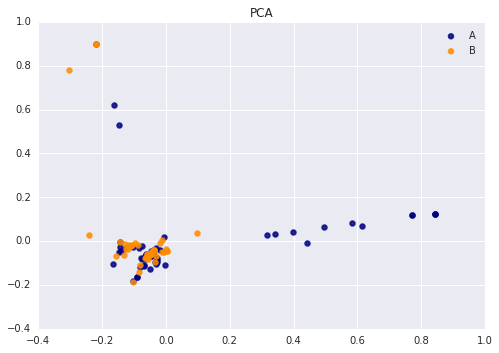

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_r = pca.fit_transform(features.toarray())

plt.figure()
colors = ['navy', 'darkorange']
target_names = ['A', 'B']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[labels == i, 0], X_r[labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')

In [11]:
df.team.to_csv('./embedding/emb.tsv', index=False)

In [12]:
import os
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = './embedding'

with tf.Graph().as_default():
    
    embedding_var = tf.Variable(features.toarray(), name='word_embedding')
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), 0)

        # Format: tensorflow/tensorboard/plugins/projector/projector_config.proto
        config = projector.ProjectorConfig()

        # You can add multiple embeddings. Here we add only one.
        embedding = config.embeddings.add()
        embedding.tensor_name = embedding_var.name
        
        # Link this tensor to its metadata file (e.g. labels).
        embedding.metadata_path = 'emb.tsv'

        # Use the same LOG_DIR where you stored your checkpoint.
        summary_writer = tf.summary.FileWriter(LOG_DIR)

        # The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
        # read this file during startup.
        projector.visualize_embeddings(summary_writer, config)

In [13]:
from google.datalab.ml._tensorboard import TensorBoard
tb = TensorBoard()
tb_pid = tb.start('./embedding')

TensorBoard was started successfully with pid 291. Click here to access it.